# COVID19 evolution analysis

#### data loading

In [240]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import tools
import plotly.express as px

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [242]:
df_naz = pd.read_csv('../../external_data/ProtezioneCivile/COVID-19/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv').drop('stato',1)
reg = pd.read_csv('../../external_data/ProtezioneCivile/COVID-19/dati-regioni/dpc-covid19-ita-regioni.csv')
prov = pd.read_csv('../../external_data/ProtezioneCivile/COVID-19/dati-province/dpc-covid19-ita-province.csv').drop('stato',1)
df_naz.index = pd.to_datetime(df_naz.index)
reg['data'] = pd.to_datetime(reg['data'])
prov['data'] = pd.to_datetime(prov['data'])
df_world_confirmed = pd.read_csv('../../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv')
df_world_deaths = pd.read_csv('../../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Deaths.csv')
df_world_recovered = pd.read_csv('../../external_data/JohnHopkins/COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Recovered.csv')
populations = pd.read_csv('../../external_data/population_data/API_SP.POP.TOTL_DS2_en_csv_v2_866861.csv', skiprows=4, engine='python').set_index('Country Name')['2018']
df_world_confirmed['pop'] = df_world_confirmed['Country/Region'].map(populations)
df_world_deaths['pop'] = df_world_deaths['Country/Region'].map(populations)
df_world_recovered['pop'] = df_world_recovered['Country/Region'].map(populations)
df_naz = tools.add_extra_features(df_naz)
regions = reg.groupby('denominazione_regione')
df_reg = {}
for item in regions.groups:
    df_reg[item] = tools.add_extra_features(regions.get_group(item)).replace((np.inf, np.nan), 0)
provinces = prov.groupby('sigla_provincia')
df_prov = pd.DataFrame()
for item in provinces.groups:
    df_prov = pd.concat((df_prov,tools.add_extra_features(provinces.get_group(item)).replace((np.inf, np.nan), 0)),0)

In [243]:
date_cols = [item for item in df_world_confirmed.columns if '/20' in item]

In [244]:
df_world_confirmed.pivot_table(index='Country/Region', values=date_cols)

,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,...,3/15/20,3/16/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20
Country/Region,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,16.0,21.0,1.0,1.0,1.0,1.0,1.0,1.0,4.0,4.0
Albania,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,42.0,51.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
Algeria,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,54.0,3.0,5.0,12.0,12.0,17.0,17.0,19.0,20.0
Andorra,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
Antigua and Barbuda,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Uruguay,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Uzbekistan,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Venezuela,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,10.0,17.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Italy

### diffusion heatmap for provinces

In [245]:
col = 'totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov[df_prov.index==df_prov.index.max()].index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

In [246]:
col = '%delta_totale_casi'
fig = px.density_mapbox(df_prov[df_prov.index==df_prov.index.max()], 
                        lat='lat', lon='long', z=col, radius=10, 
                        hover_name='denominazione_provincia',
                        zoom=5,  height=800,
                        #animation_frame=df_prov.index,
                        mapbox_style="stamen-terrain",
                        title = col + ' on ' + str(df_prov.index.max()))
fig.show()

### National evolution

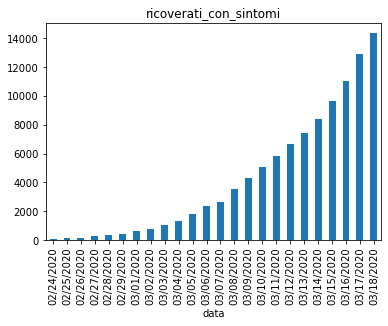

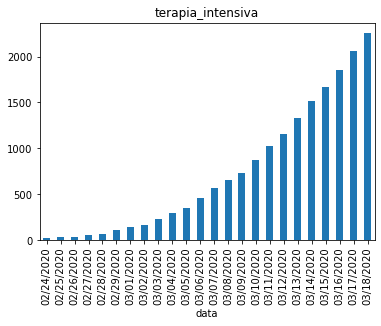

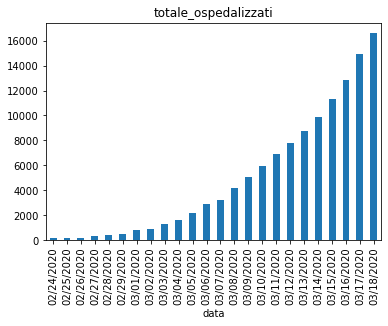

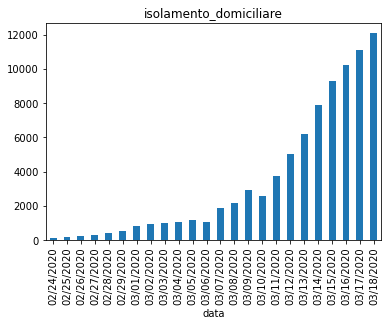

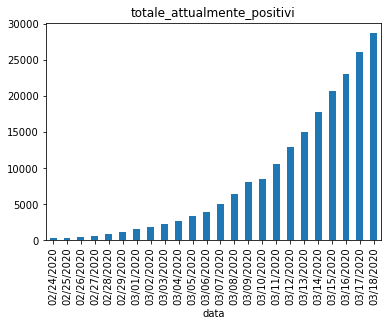

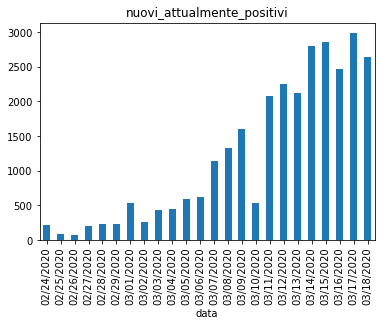

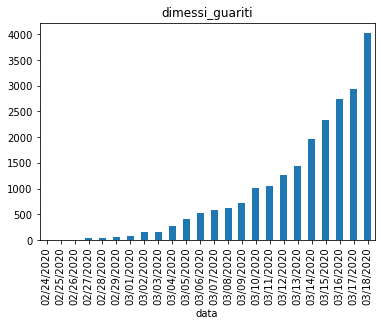

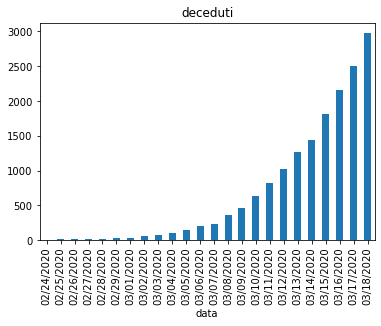

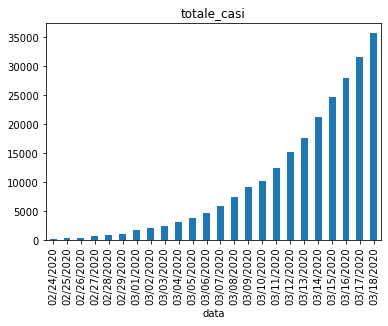

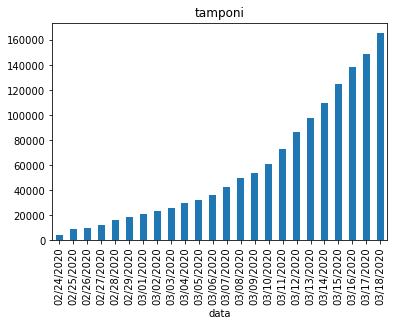

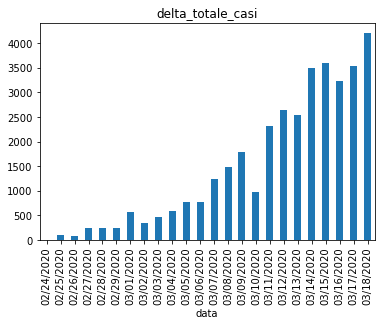

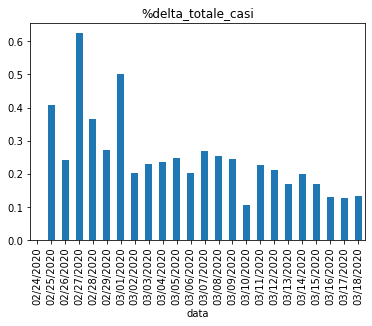

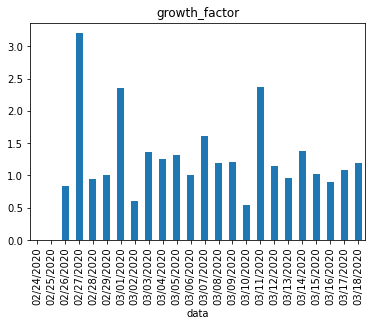

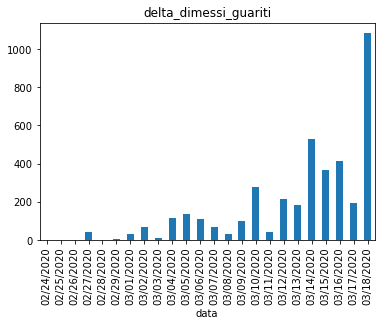

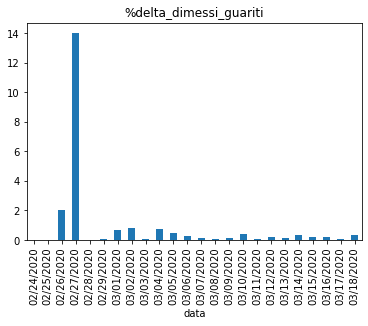

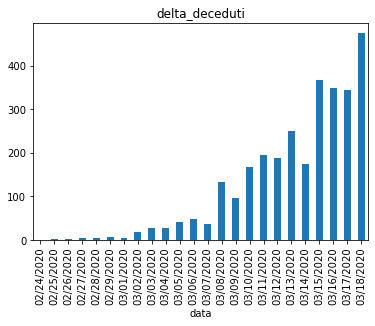

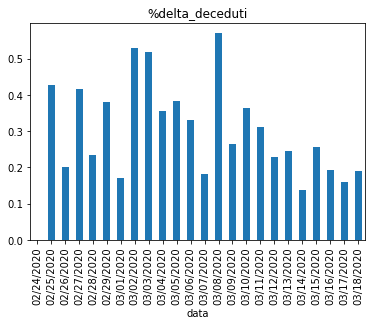

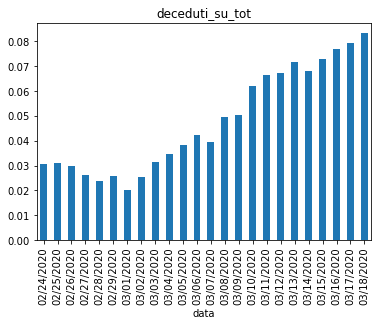

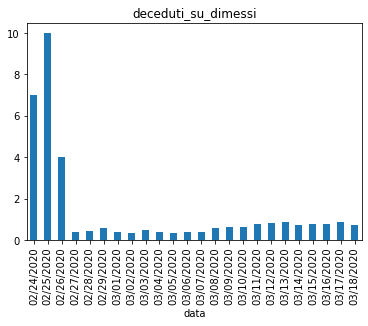

In [247]:
for col in df_naz.columns:
    plt.figure()
    df_naz[col].plot(kind='bar', title=col)    

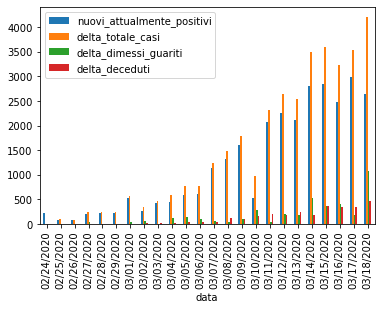

In [248]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].plot(kind='bar')

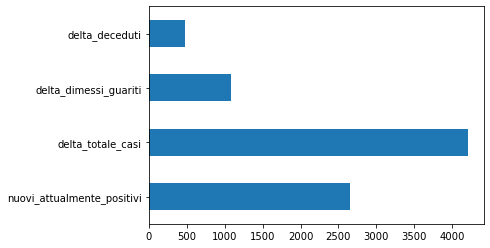

In [249]:
df_naz[['nuovi_attualmente_positivi', 'delta_totale_casi','delta_dimessi_guariti','delta_deceduti']].iloc[-1].plot(kind='barh')

Text(0.5, 1.0, "variazione giornaliera nuovi casi per l'Abruzzo")

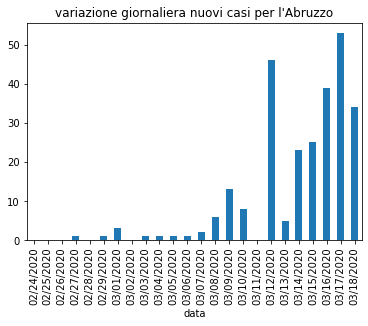

In [250]:
df_reg['Abruzzo']['delta_totale_casi'].plot(kind='bar')
plt.title("variazione giornaliera nuovi casi per l'Abruzzo")

### Logistic model evolution

### National Analysis

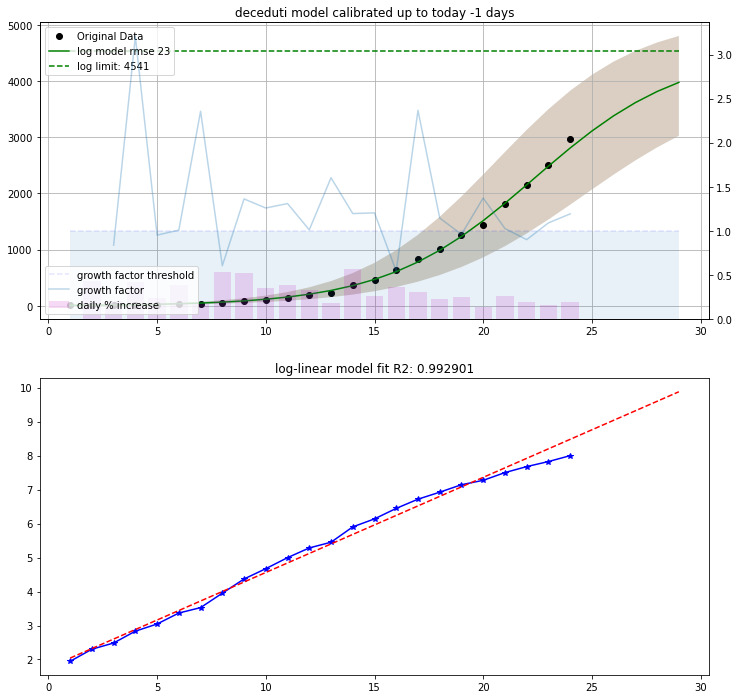

next day prediction for log model:  3111
data
03/14/2020    1441
03/15/2020    1809
03/16/2020    2158
03/17/2020    2503
03/18/2020    2978
Name: deceduti, dtype: int64


In [286]:
tools.plot_model(df_naz, 'deceduti', backward_fit=1, stdev=2, forward_look=5, plotlimit=True, show_pol=False, show_exp=False)

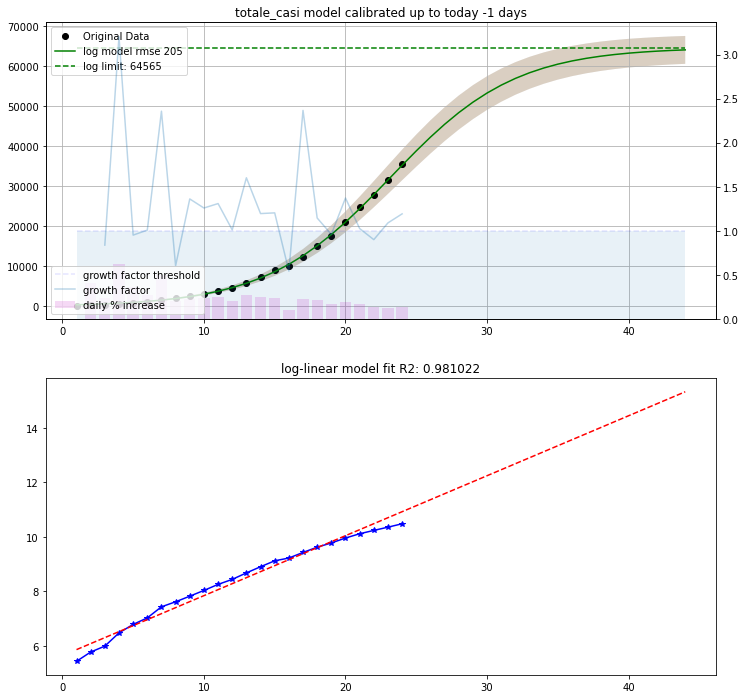

next day prediction for log model:  38885
data
03/14/2020    21157
03/15/2020    24747
03/16/2020    27980
03/17/2020    31506
03/18/2020    35713
Name: totale_casi, dtype: int64


In [274]:
tools.plot_model(df_naz, 'totale_casi', backward_fit=1, forward_look=20, plotlimit=True, show_pol=False, show_exp=False)

### Regional Analysis

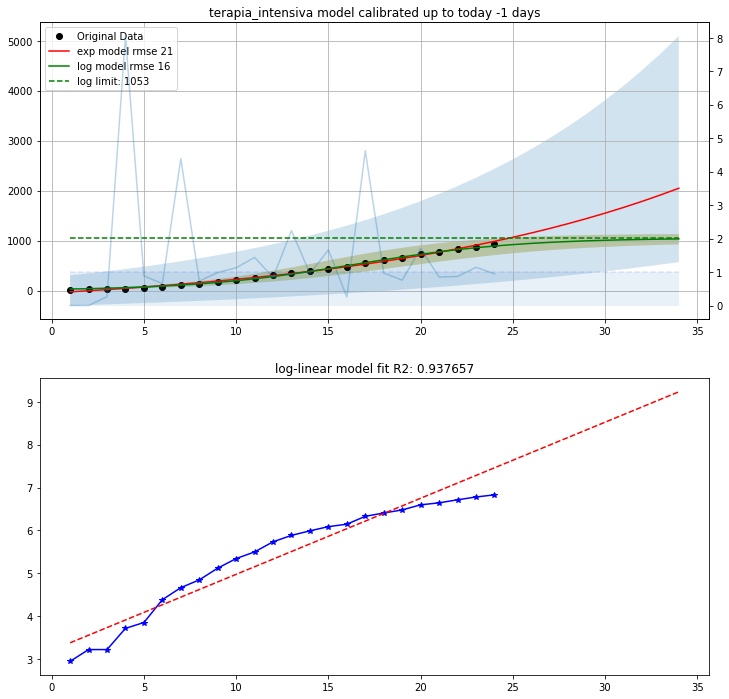

next day prediction for log model:  920
next day prediction for exp model:  1066
data
03/14/2020    732
03/15/2020    767
03/16/2020    823
03/17/2020    879
03/18/2020    924
Name: terapia_intensiva, dtype: int64


In [290]:
tools.plot_model(df_reg['Lombardia'], 'terapia_intensiva', backward_fit=1, stdev=2, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=True)

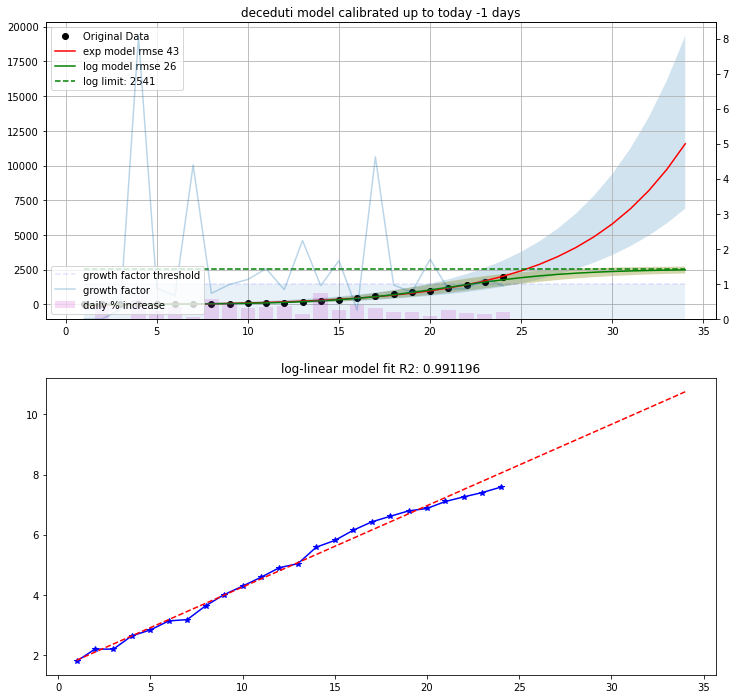

next day prediction for log model:  1930
next day prediction for exp model:  2422
data
03/14/2020     966
03/15/2020    1218
03/16/2020    1420
03/17/2020    1640
03/18/2020    1959
Name: deceduti, dtype: int64


In [280]:
tools.plot_model(df_reg['Lombardia'], 'deceduti', backward_fit=1, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=True)

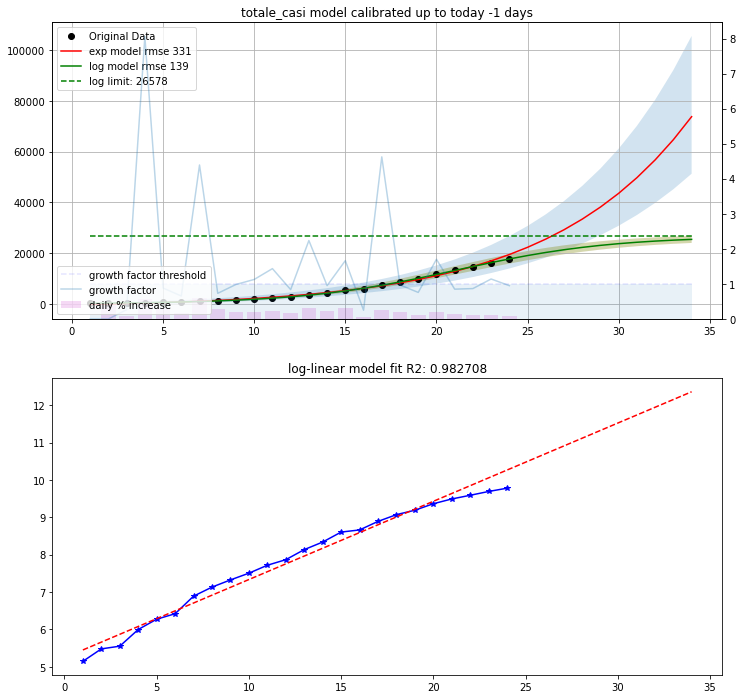

next day prediction for log model:  19033
next day prediction for exp model:  22282
data
03/14/2020    11685
03/15/2020    13272
03/16/2020    14649
03/17/2020    16220
03/18/2020    17713
Name: totale_casi, dtype: int64


In [281]:
tools.plot_model(df_reg['Lombardia'], 'totale_casi', backward_fit=1, forward_look=10, plotlimit=True, 
                 show_pol=False, show_exp=True)

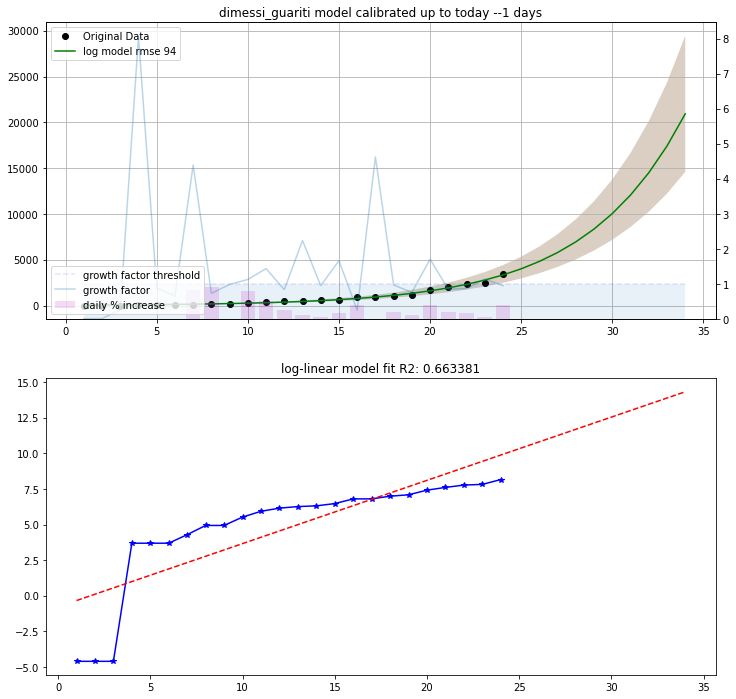

next day prediction for log model:  4009
data
03/14/2020    1660.0
03/15/2020    2011.0
03/16/2020    2368.0
03/17/2020    2485.0
03/18/2020    3488.0
Name: dimessi_guariti, dtype: float64


In [283]:
tools.plot_model(df_reg['Lombardia'].replace(0,0.01), 'dimessi_guariti', backward_fit=-1, forward_look=10, plotlimit=False, 
                 show_pol=False, show_exp=False)

### Lombardy evolution for provinces

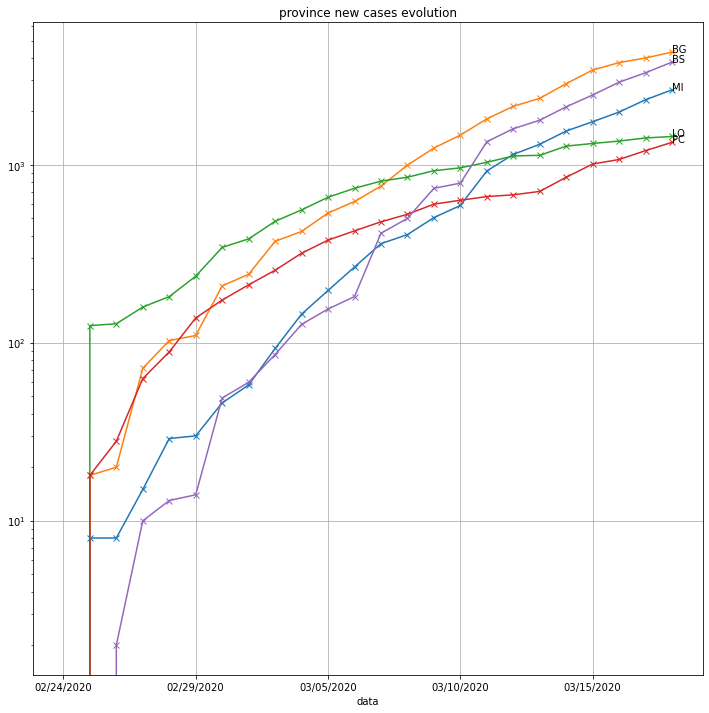

In [301]:
prov_analysis = df_prov.reset_index().pivot_table(index='data', columns='sigla_provincia', 
            values='totale_casi')[['MI', 'BG', 'LO', 'PC', 'BS']]
prov_analysis.plot(kind='line', style='x-', figsize=(12,12), legend=False)
for label in ['MI', 'BG', 'LO', 'PC', 'BS']:
    plt.annotate(label, xy=(len(prov_analysis)-1, prov_analysis[label].iloc[-1]),textcoords='data')
plt.title('province new cases evolution')
plt.grid()
plt.yscale('log')

### china comparison

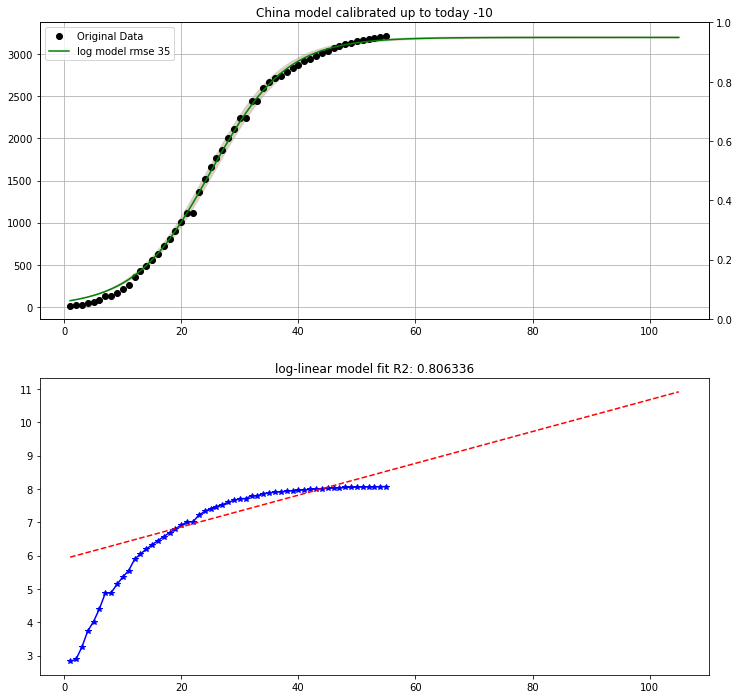

next day prediction for log model:  3174
2020-03-12    3172
2020-03-13    3180
2020-03-14    3193
2020-03-15    3203
2020-03-16    3217
Name: China, dtype: int64


In [124]:
china_deaths = df_world_deaths[df_world_deaths['Country/Region']=='China'].groupby('Country/Region').sum().drop('Lat',1).drop('Long',1).T#
china_deaths.index = pd.to_datetime(china_deaths.index)
tools.plot_model(china_deaths, 'China', backward_fit=-10, forward_look=50, plotlimit=False, show_pol=False, show_exp=False)

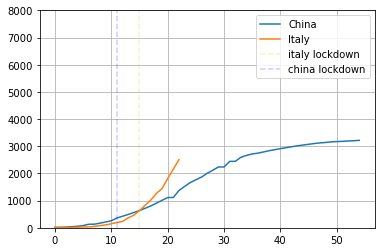

In [125]:
df_compare = pd.DataFrame(data=pd.concat([china_deaths.reset_index(drop=True), df_naz['deceduti'].reset_index(drop=True)], 
                            axis=1))
df_compare.columns = ['China','Italy']
df_compare.plot()
plt.ylim(0,8000)
plt.grid()
plt.axvline(x=15, label='italy lockdown', alpha=0.2, color='y', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='b', linestyle='--')
plt.legend()

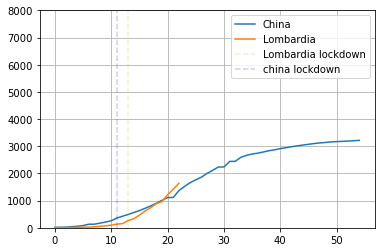

In [126]:
df_compare = pd.DataFrame(data=pd.concat([china_deaths.reset_index(drop=True), 
                    df_reg['Lombardia']['deceduti'].reset_index(drop=True)], axis=1))
df_compare.columns = ['China','Lombardia']
df_compare.plot()
plt.ylim(0,8000)
plt.grid()
plt.axvline(x=13, label='Lombardia lockdown', alpha=0.2, color='y', linestyle='--')
plt.axvline(x=11, label='china lockdown', alpha=0.2, color='b', linestyle='--')
plt.legend()

## World comparisons

In [440]:
countries = ['Spain', 'Italy', 'Germany', 'France', 'United Kingdom', 'US']
df_countries = pd.DataFrame()
df_countries_stripped = pd.DataFrame()
for country in countries:
    print(country)
    df_countries = pd.concat((df_countries, df_world_deaths.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0)), 1)
    temp = df_world_deaths.groupby('Country/Region').sum().loc[country].drop(['Lat','Long'],0).reset_index(drop=True)    
    temp = temp.loc[~(temp==0)].reset_index(drop=True).iloc[:-1]    
    df_countries_stripped= pd.concat((df_countries_stripped,  temp), 1)
df_countries.columns = countries
#df_countries_stripped = pd.concat((pd.DataFrame(np.zeros((1,len(countries))), columns=countries), df_countries_stripped),0).reset_index(drop=True)

Spain
Italy
Germany
France
United Kingdom
US


In [434]:
start_dates = {}
start_dates['Spain'] = '3/3/20'
start_dates['Italy'] = '2/21/20'
start_dates['Germany'] = '3/9/20'
start_dates['France'] = '2/25/20'
start_dates['United Kingdom'] = '3/5/20'
start_dates['US'] = '3/1/20'

In [435]:
populations.loc['US'] = populations.loc['United States']

KeyError: 'Russia'

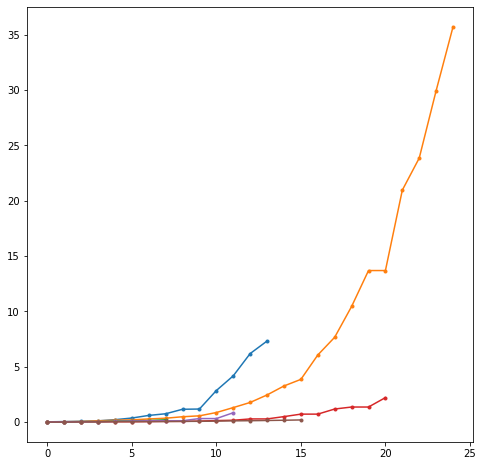

In [436]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    if country=='France':
        plt.plot(df_countries_stripped[country].shift(-10) / populations.loc[country] *1e6, '.-', label=country, )
    else:
        plt.plot(df_countries_stripped[country] / populations.loc[country] *1e6, '.-', label=country, )
plt.title('decessi per milione di abitante')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0.01, top=100)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

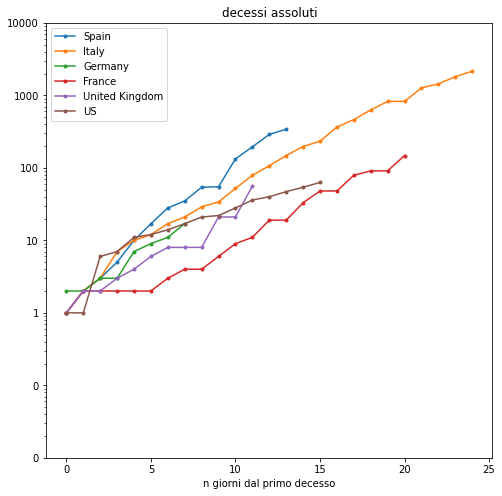

In [432]:
fig, ax = plt.subplots(figsize=(8,8))
for country in countries:
    if country=='France':
        plt.plot(df_countries_stripped[country].shift(-10), '.-', label=country)
    else:
        plt.plot(df_countries_stripped[country], '.-', label=country)
plt.title('decessi assoluti')
plt.xlabel('n giorni dal primo decesso')
plt.yscale('log')
plt.ylim(bottom=0.01, top=10000)
from matplotlib.ticker import ScalarFormatter
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.xaxis.set_major_formatter(ScalarFormatter())
plt.legend()

In [410]:
df_countries_stripped[country].iloc[0:2]

0    1.0
1    1.0
Name: US, dtype: float64

In [398]:
country = 'US'
(df_countries_stripped[country] / populations.loc[country]*1e6).fillna(0)

0     0.000000
1     0.003057
2     0.003057
3     0.018339
4     0.021396
5     0.033622
6     0.036678
7     0.042792
8     0.051961
9     0.064187
10    0.067244
11    0.085583
12    0.110035
13    0.122262
14    0.143657
15    0.165053
16    0.192562
17    0.000000
18    0.000000
19    0.000000
20    0.000000
21    0.000000
22    0.000000
23    0.000000
24    0.000000
25    0.000000
26    0.000000
27    0.000000
28    0.000000
29    0.000000
30    0.000000
31    0.000000
Name: US, dtype: float64

## simulation using Facebook Phrophet Model

In [127]:
from fbprophet import Prophet
from fbprophet.plot import add_changepoints_to_plot

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
c:\anaconda3\envs\coronavirus\lib\site-packages\pystan\misc.py:399: FutureWarning:

Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
Traceback (most recent call last):
  File "c:\anaconda3\envs\coronavirus\lib\site-packages\matplotlib\axis.py", line 1573, in convert_units
    ret = self.converter.convert(x, self.units, self)
  File "c:\anaconda3\envs\coronavirus\lib\site-packages\matplotlib\category.py", line 61, in convert
    unit.update(values)
  File "c:\

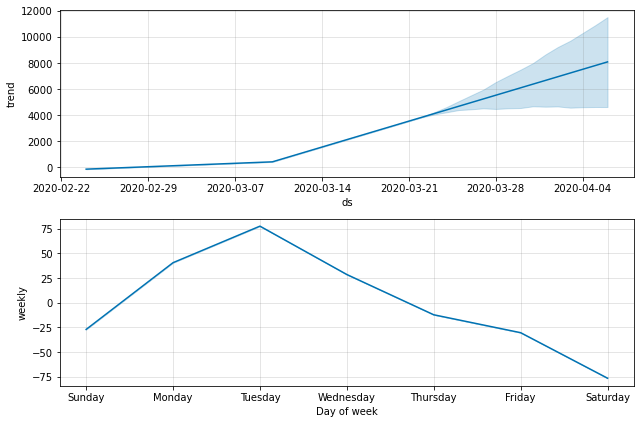

ValueError: view limit minimum -7.930656e+16 is less than 1 and is an invalid Matplotlib date value. This often happens if you pass a non-datetime value to an axis that has datetime units

<Figure size 720x432 with 1 Axes>

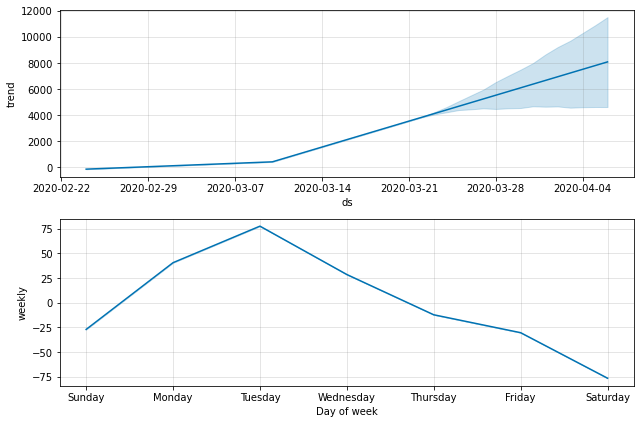

In [128]:

y = 'deceduti'
train_data = pd.DataFrame()
train_data['ds']=df_naz.index
train_data['y']=df_naz[y].reset_index(drop=True).values
growth = 'linear'
cap = 4000
floor = 0
if growth=='logistic':
    train_data['cap'] = cap
    train_data['floor'] = floor

m = Prophet(growth = growth, changepoints=['2020-03-10'], changepoint_prior_scale=0.75)
m.fit(train_data)
future = m.make_future_dataframe(periods=20)
if growth=='logistic':
    future['cap'] = cap
    future['floor'] = floor
forecast = m.predict(future)
fig = m.plot(forecast)

a = add_changepoints_to_plot(fig.gca(), m, forecast)
plt.title('prophet forecast for ' + y)
plt.plot(train_data.set_index('ds')['y'],'r*',label='actual data')
#plt.axvspan(whole_data.iloc[0]['ds'], train_data.iloc[-1]['ds'], alpha=0.15, color='red', label='train period')
#plt.axvspan(test_data.iloc[0]['ds'], test_data.iloc[-1]['ds'], alpha=0.15, color='green', label='test period')
plt.legend()
m.plot_components(forecast)
